<a href="https://colab.research.google.com/github/Lightziro/ml-classifier-market-news/blob/main/classifier_market_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Классификатор новостей на фондовом рынке даёт прогноз по влиянию новости на котировку акции/фондового рынка в целом**

# Подготовка и импорт датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
import re
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

punc_translator = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_json('drive/MyDrive/dataset.json')
data.head()

,title,score
0,How Target Can Dominate This Holiday Season,neutral
1,3 5G Stocks You Can Buy and Hold for the Next ...,neutral
2,Cathie Wood Goes Dumpster Diving: 3 Stocks She...,positive
3,Disney Delivers The Bear Necessities,positive
4,Outperforming The S&P 500 By Trading The Top 1...,neutral


# Визуализация датасета(Visualization of the dataset)

In [ ]:
data['score'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [ ]:
data.shape

(711, 2)

**Графический подсчёт типов новостей(Graphical calculation of news types)**

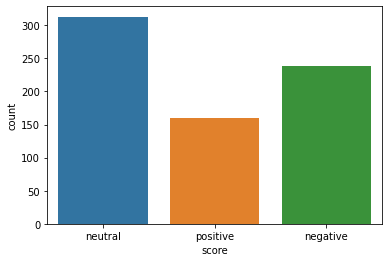

In [ ]:
sns.countplot(data.score)

In [ ]:
data['title_length'] = data['title'].str.len()
print(data['title_length'])

0       43
1       52
2       58
3       36
4      107
      ... 
706     71
707     63
708     53
709     34
710    126
Name: title_length, Length: 711, dtype: int64


**График распределения длинны новостного заголовка(The plot of the distribution of the length of the news headline)**

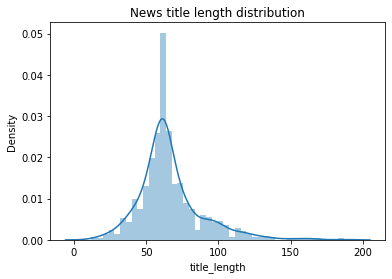

In [ ]:
sns.distplot(data['title_length']).set_title('News title length distribution');


**Визуализация частоты употребления слов в заголовке новостей**

In [ ]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=1280, height=720, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

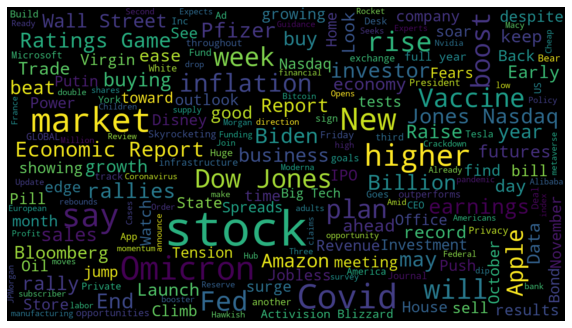

In [ ]:
subset=data[data.score == "positive"]
words =" ".join(subset.title.values)
create_wordcloud(words)

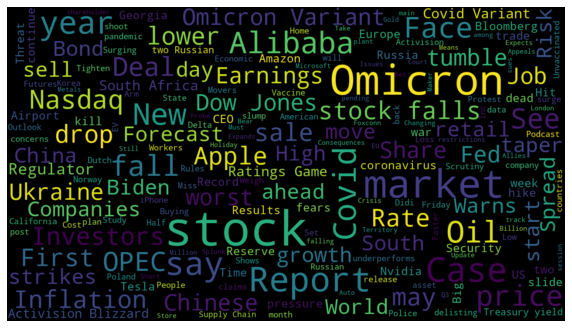

In [ ]:
subset=data[data.score == "negative"]
words =" ".join(subset.title.values)
create_wordcloud(words)

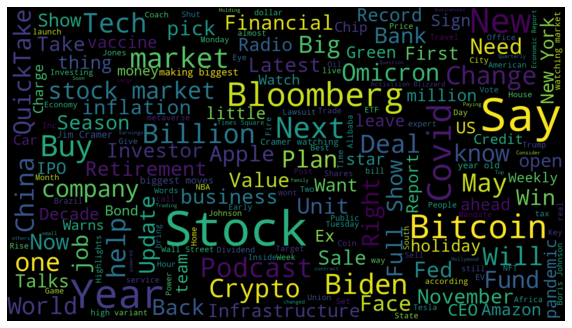

In [ ]:
subset=data[data.score == "neutral"]
words =" ".join(subset.title.values)
create_wordcloud(words)

# Предварительная обработка текста

**Формирование стоп-слов**

In [ ]:
custom_stop_words = pd.read_json('drive/MyDrive/custom_words.json', orient='values', typ='series')
list_words = custom_stop_words.values.tolist()
print(list_words)
main_stop_words = list_words + stopwords.words('english')

['Alibaba', 'Apple', 'Market', 'Bloomberg']


**Условия (Condition):<br>**
1) Преобразование в нижний регистр<br>
2) Очистка от \r, \n<br>
3) Очистка от всех символов(не будут играть важную роль)<br>
4) Очистка всех знаков препринания<br>
5) Очистка стоп-слов<br>
6) Лемматизация текста в нормальную форму

In [ ]:
def processText(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(r'\d+', '', text)
    text = text.translate(punc_translator)
    
    stop_words = set(main_stop_words) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    
    for word in word_tokens: 
        if word not in stop_words: 
            filtered_sentence.append(lemmatizer.lemmatize(word, pos ='v'))
    
    text = " ".join(filtered_sentence)
    return text

In [ ]:
data['output_text'] = data['title'].apply(processText)

In [ ]:
data.head()

,title,score,title_length,output_text
0,How Target Can Dominate This Holiday Season,neutral,43,target dominate holiday season
1,3 5G Stocks You Can Buy and Hold for the Next ...,neutral,52,g stock buy hold next decade
2,Cathie Wood Goes Dumpster Diving: 3 Stocks She...,positive,58,cathie wood go dumpster dive stock buy
3,Disney Delivers The Bear Necessities,positive,36,disney deliver bear necessities
4,Outperforming The S&P 500 By Trading The Top 1...,neutral,107,outperform sp trade top stock large hedge fund...


In [ ]:
label_encoder = preprocessing.LabelEncoder() 
data['output_target']= label_encoder.fit_transform(data['score']) 

In [ ]:
data.head()

,title,score,title_length,output_text,output_target
0,How Target Can Dominate This Holiday Season,neutral,43,target dominate holiday season,1
1,3 5G Stocks You Can Buy and Hold for the Next ...,neutral,52,g stock buy hold next decade,1
2,Cathie Wood Goes Dumpster Diving: 3 Stocks She...,positive,58,cathie wood go dumpster dive stock buy,2
3,Disney Delivers The Bear Necessities,positive,36,disney deliver bear necessities,2
4,Outperforming The S&P 500 By Trading The Top 1...,neutral,107,outperform sp trade top stock large hedge fund...,1


# Разделение данных на тестовые и обучающие

In [ ]:
x_train, x_test, target_train, target_test = train_test_split(data['output_text'], 
                                                    data['output_target'], 
                                                    test_size=0.3, 
                                                    random_state=42)

# Векторизация заголовка новостей
*ВАЖНО: Указать тип векторайзера в переменную selected_vectorizer*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

selected_vectorizer = 'tf'

vectorizer_type = {
    'cv': CountVectorizer(encoding='utf-8', lowercase=False, stop_words=None, max_features=250),
    'tf': TfidfVectorizer(encoding='utf-8', stop_words=None, lowercase=False, sublinear_tf=True, norm='l2', max_df=1.0, min_df=10, max_features=250)
}

vectorizer = vectorizer_type[selected_vectorizer]

title_train = vectorizer.fit_transform(x_train).toarray()
print(title_train)

title_test = vectorizer.transform(x_test).toarray()
print(title_test)

[[0.         0.         0.         ... 0.84435254 0.         0.        ]
 [0.         0.77863577 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.70062725]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Создание модели и подбор наилучших параметров

**Создание моделей и выбор параметров для поиска наилучших**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from scipy.stats import randint

models = {
    'rfc': RandomForestClassifier(criterion='gini', max_depth=15, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=300),
    'lr': LogisticRegression(C=1, penalty='l2'),
    'knc': KNeighborsClassifier(algorithm='kd_tree', n_neighbors=1, p=5, weights='uniform'),
    'dtc': DecisionTreeClassifier(criterion='entropy', max_depth=None),
    'gnb': GaussianNB(),
    'svc': svm.SVC(C=10, gamma=0.001, kernel='linear')
}

models_params = {
    'svc': {
        'kernel': ['rbf', 'linear'], 
        'gamma': [1e-3, 1e-4], 
        'C': [1, 10, 100, 1000]
    },
    'rfc': {
        'n_estimators': [100, 200, 300], 
        'max_features': ['auto', 'sqrt', 'log2'], 
        'max_depth' : [5, 8, 15], 
        'criterion' :['gini', 'entropy'], 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 5, 10]
    },
    'knc': {
        'n_neighbors': [1, 3, 5, 9, 11, 14],
        'p': [1, 2, 5],
        'weights': ['uniform', 'distance'], 
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'dtc': {
        'criterion': ['gini', 'entropy'], 
        'max_depth': [3, None], 
    },
    'lr': {
        'C': [0.1, 0.001, 1],
        'penalty': ['l1', 'l2']
    },
    'gnb': {}
}

# print('Accuracy: ', accuracy_score(labels_test, model_predictions))
# print(classification_report(labels_test, model_predictions))

**Реализация метода для поиска наилучших параметров для модели**

In [ ]:
from sklearn.model_selection import GridSearchCV

def getBestParamsModel(type_model):
  
  grid = GridSearchCV(models[type_model], models_params[type_model], scoring='f1_weighted', cv = 3, verbose = 1)
  grid.fit(title_train, target_train)
  
  best_params = grid.best_params_
  print(f"Лучшие параметры: {best_params}")
  return best_params

**Выбор модели и настройка параметров**

In [ ]:
search_best = True
select_model = 'knc'

model = models[select_model]

if search_best:
  params = getBestParamsModel(select_model)
  model.set_params(**params)
print(f"Параметры модели: \n{model.get_params()}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Лучшие параметры: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Параметры модели: 
{'algorithm': 'kd_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


In [ ]:
model = model.fit(title_train, target_train)
prediction = model.predict(title_test)
print(f"accuracy {accuracy_score(prediction, target_test)}")
print(classification_report(target_test, prediction))

accuracy 0.5186915887850467
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        67
           1       0.55      0.84      0.67       103
           2       0.22      0.05      0.08        44

    accuracy                           0.52       214
   macro avg       0.41      0.41      0.38       214
weighted avg       0.46      0.52      0.46       214



# Поиск модели с наилучшим результатом
*ВАЖНО: Очень долгий процесс*

In [ ]:
search_best = True
models_list = ['svc', 'dtc', 'knc', 'lr', 'rfc']
list_score = {}

for model_item in models_list:
  
  model = models[model_item]
  print(f"Итерация по модели: {model_item}")
  
  if search_best:
    params = getBestParamsModel(model_item)
    model.set_params(**params)
  print(f"Параметры модели: \n{model.get_params()}")
  

  model = model.fit(title_train, target_train)
  prediction = model.predict(title_test)
  accuracy = accuracy_score(prediction, target_test)
  list_score[model_item] = accuracy
  print(f"accuracy {accuracy}")
  print(f"{classification_report(target_test, prediction)}\n")
best_model = max(list_score, key=list_score.get)
print(f"Наилучшая модель {best_model}, с результатом: {list_score[best_model]}")

Итерация по модели: svc
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Параметры модели: 
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
accuracy 0.5186915887850467
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        67
           1       0.59      0.67      0.63       103
           2       0.41      0.32      0.36        44

    accuracy                           0.52       214
   macro avg       0.48      0.47      0.47       214
weighted avg       0.51      0.52      0.51       214


Итерация по модели: dtc
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': No